Wprowadzenie bibliotek:

In [69]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sb
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler

Załadowanie danych:

In [70]:
drive.mount('/content/drive')
base_path = Path('/content/drive/MyDrive/ml kurs/titanic.csv')
df = pd.read_csv(base_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Zaczniemy od usunięcia niepotrzebnych kolumn
 Aby model uczenia maszynowego działał jak najlepiej, należy pozbyć się kolumn (cech), które nie mają zbytniego wpływu na klasyfikację (nasza predykowana cecha to kolumna survived, pasażerowie są klasyfikowani binarnie - 0: nie przeżyli, 1: przeżyli)
 W tym celu usuniemy kolumny PassengerId, Ticket, Cabin oraz Embarked

In [71]:
survival = df['Survived']
filtered_data = df.drop(['PassengerId','Survived','Name','Ticket','Cabin','Embarked'],axis=1) # predykowaną cechę survived również usuwamy
filtered_data.dropna(inplace=True)  # kolumna 'cabin' miała dużo pustych rejestrów więc zrobienie tego przed jej usunięciem drastycznie zmniejszyłoby ilość pasażerów branych pod uwagę
                                    # Po jej usunięciu możemy wykluczyć osoby z niepełnymi rejestrami na przykład tymi dotyczącymi wieku
filtered_data.head(7) # wcześniej pasażer z indeksem 6 nie miał podanego wieku, został on usunięty i teraz wszystko się zgadza

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,male,22.0,1,0,7.2500
1,1,female,38.0,1,0,71.2833
2,3,female,26.0,0,0,7.9250
3,1,female,35.0,1,0,53.1000
4,3,male,35.0,0,0,8.0500
6,1,male,54.0,0,0,51.8625
7,3,male,2.0,3,1,21.0750


Aby zamienić płeć danej kategorialnej na numeryczną użyjemy onehotencoding

In [72]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_array = encoder.fit_transform(filtered_data[['Sex']])
encoder_columns = encoder.get_feature_names_out(['Sex'])
is_male = pd.DataFrame(encoded_array, columns=["Is male"])

# podmieniamy tę wersję płci w naszej ramce
filtered_data = filtered_data.reset_index(drop=True)
is_male = is_male.reset_index(drop=True)
filtered_data['Is male'] = is_male
filtered_data.drop(columns=['Sex'],inplace=True)


filtered_data

,Pclass,Age,SibSp,Parch,Fare,Is male
0,3,22.0,1,0,7.2500,1.0
1,1,38.0,1,0,71.2833,0.0
2,3,26.0,0,0,7.9250,0.0
3,1,35.0,1,0,53.1000,0.0
4,3,35.0,0,0,8.0500,1.0
...,...,...,...,...,...,...
626,3,25.0,0,0,7.0500,1.0
627,2,27.0,0,0,13.0000,1.0
628,1,19.0,0,0,30.0000,0.0
629,1,26.0,0,0,30.0000,1.0


### Podział pasażerów ze względu na przeżycie
podzielimy teraz nasz zbiór danych na ludzi którzy zostali uratowani i na tych, którzy nie przeżyli aby móc eksplorować cechy w oparciu o predykowaną cechę

In [73]:
survivors = filtered_data[survival == 1]
casualties = filtered_data[survival == 0]


/tmp/ipython-input-3166148278.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survivors = filtered_data[survival == 1]
/tmp/ipython-input-3166148278.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  casualties = filtered_data[survival == 0]


### Wykresy
wpierw, zobaczmy jak wyglądają rozkłady pojedyńczych cech:


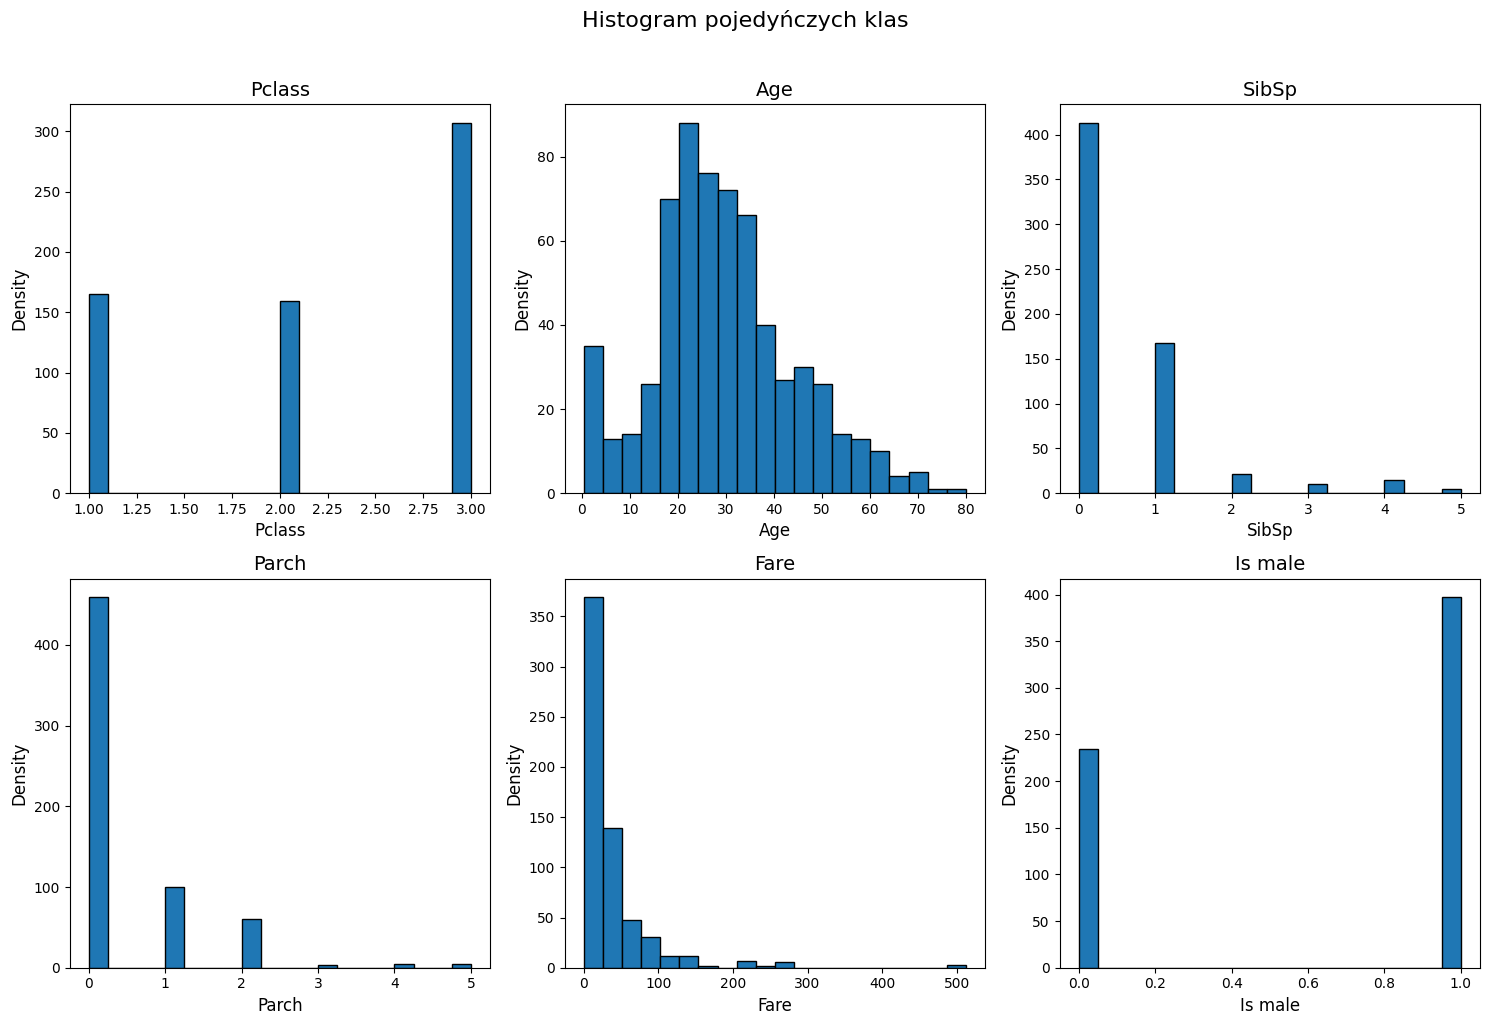

In [74]:
num_cols = filtered_data.select_dtypes(include=['float64', 'int64']).columns
cols = 3
rows = (len(num_cols) + cols - 1) // cols  # zaokrąglamy w górę

plt.figure(figsize=(15, 5 * rows))
plt.suptitle('Histogram pojedyńczych klas', fontsize=16, y=1.02)
for i, col in enumerate(num_cols, start=1):
    plt.subplot(rows, cols, i)
    plt.hist(filtered_data[col], bins=20, edgecolor='black')
    plt.title(f'{col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Density', fontsize=12)


plt.tight_layout()
plt.show()

### Wnioski:
Możemy łatwo zauważyć, że średni wiek pasażerów jest w przedziale 15-35 lat, większość to mężczyźni, tańsze bilety były kupowane najwięcej co pokrywa się z rozkładem ludzi w poszczególnych klasach jak również pokrywa się duży brak rodziców/dzieci z brakiem rodzeństwa/drugiej połówki.

# Zależności między klasami z uwzględnieniem predykowanej cechy:

### płeć i wiek w zależności od ocalenia:


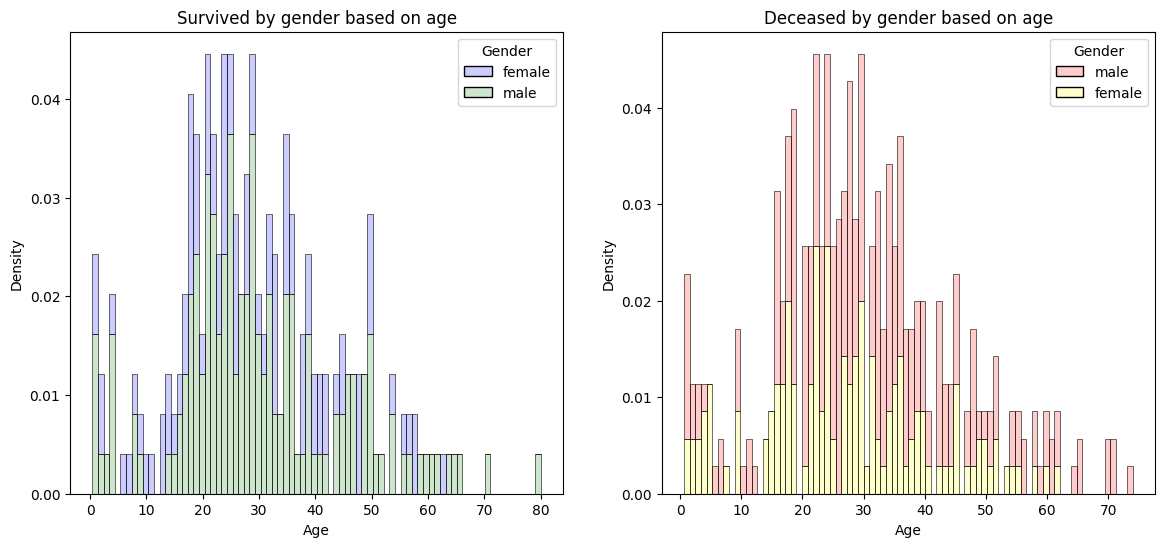

In [75]:
survivors_plot = survivors.copy()
casualties_plot = casualties.copy()

survivors_plot['Gender'] = survivors_plot['Is male'].map({1: 'male', 0: 'female'})
casualties_plot['Gender'] = casualties_plot['Is male'].map({1: 'male', 0: 'female'})

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sb.histplot(
    survivors_plot, x='Age',alpha=0.2, bins=80, hue='Gender', ax=ax[0],
    stat="density", multiple="stack", palette={"male": "green", "female": "blue"}
)
sb.histplot(
    casualties_plot, x='Age',alpha=0.2, bins=80, hue='Gender', ax=ax[1],
    stat="density", multiple="stack", palette={"male": "red", "female": "yellow"}
)
ax[0].set_title("Survived by gender based on age")
ax[1].set_title("Deceased by gender based on age")
plt.show()

Gdy porównujemy naraz płeć i przeżywalność możemy zauważyć, że znacznie większa liczba mężczyzn umarła niż kobiet, co zapewne jest spowodowane że kobiety wraz z dziećmi były wysyłane w pierwszej kolejności do ratunku.
Oba wykresy przypominają rozkład normalny wieku w jakim osoby przeżyły/umarły, nie mniej na wykresie ocaleńców średnia tego rozkładu jest lekko przesunięta
 "w lewo" co również dowodzi na to że młode osoby były ratowane w pierwszej kolejności

### Przeżycie w zależności od rodzeństwa

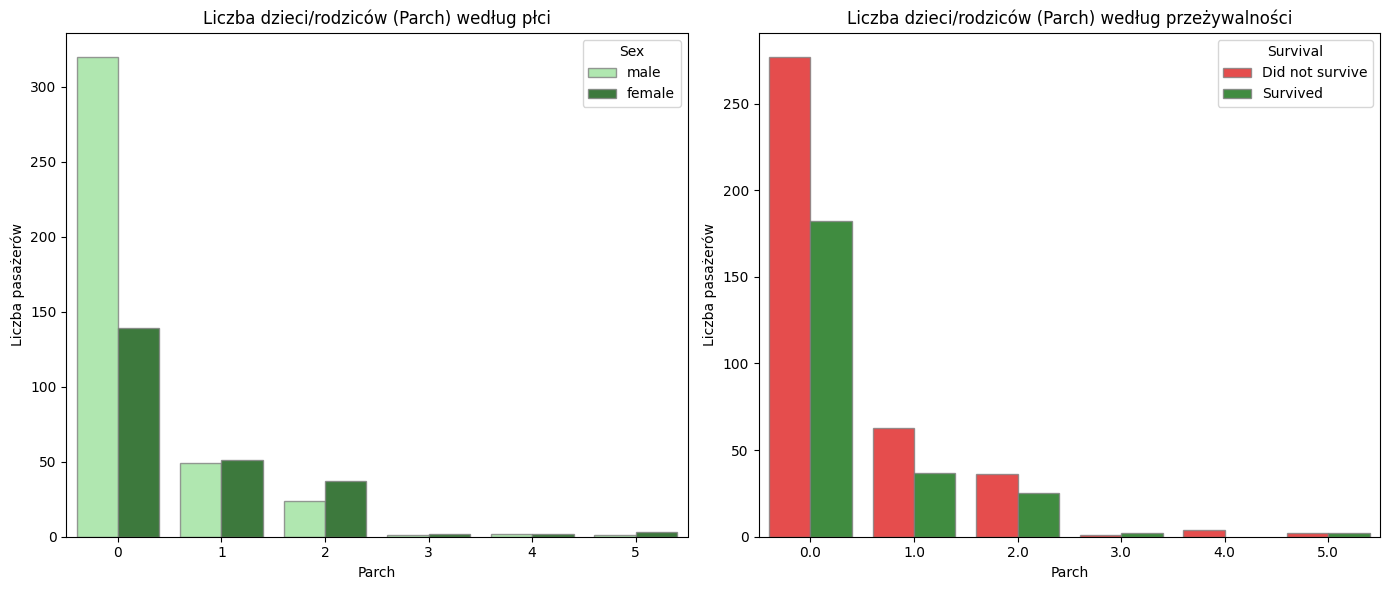

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

gender_hue = filtered_data['Is male'].map({1: 'male', 0: 'female'})
survived_hue = survival.map({1: 'Survived', 0: 'Did not survive'})

sb.countplot(data=filtered_data, x='Parch', hue=gender_hue, palette={"male": "lightgreen", "female": "darkgreen"}, edgecolor='gray', alpha=0.8, ax=axes[0])
axes[0].set_title("Liczba dzieci/rodziców (Parch) według płci")
axes[0].set_xlabel("Parch")
axes[0].set_ylabel("Liczba pasażerów")
axes[0].legend(title='Sex')

sb.countplot(data=filtered_data, x='Parch', hue=survived_hue, palette={"Survived": "green", "Did not survive": "red"}, edgecolor='gray', alpha=0.8, ax=axes[1])
axes[1].set_title("Liczba dzieci/rodziców (Parch) według przeżywalności")
axes[1].set_xlabel("Parch")
axes[1].set_ylabel("Liczba pasażerów")
axes[1].legend(title='Survival')

plt.tight_layout()
plt.show()


Jeśli chodzi o związek między ilością dzieci a przetrwaniem to dla większej liczby dzieci śmiertelność dalej przewyższa ocaleńców pomimo faktu dla większej ilości dzieci to kobiety dominują liczebnie a mimo wszystko takie osoby częściej umierały niż przeżywały, co może nas skłonić do teori że matki z dużą ilością potomstwa stawiały życie własnych dzieci nad swoim.

### cena za bilet:

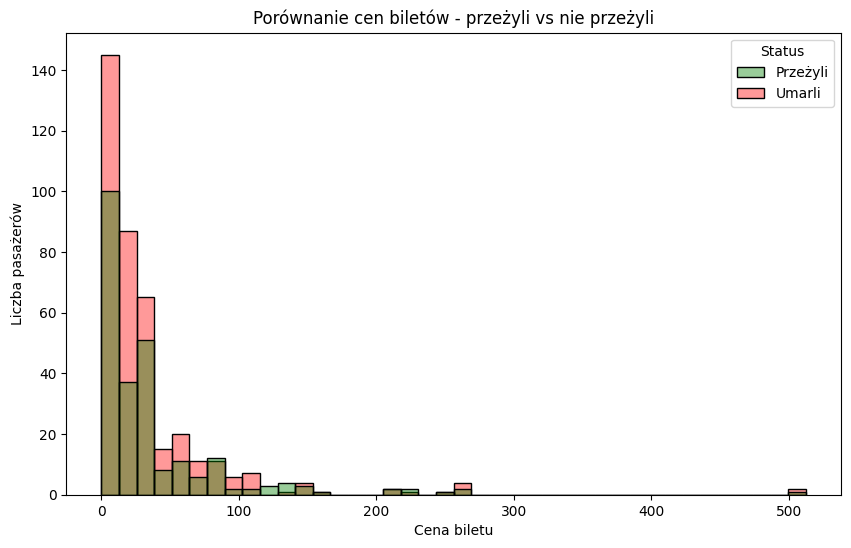

In [77]:
fare_data = pd.concat([
    survivors.assign(Status="Przeżyli"),
    casualties.assign(Status="Umarli")
])

plt.figure(figsize=(10, 6))
sb.histplot(
    fare_data,
    x='Fare',
    hue='Status',
    bins=40,
    stat='count',
    multiple='layer',
    alpha=0.4,
    edgecolor='black',
    palette={"Przeżyli": "green", "Umarli": "red"}
)

plt.title("Porównanie cen biletów - przeżyli vs nie przeżyli")
plt.xlabel("Cena biletu")
plt.ylabel("Liczba pasażerów")
plt.show()


Na pierwszy rzut oka można uznać, że niezależnie od ceny biletu i tak jest więcej ofiar niż ocaleńców, nie mniej jednak wraz ze wzrostem cen biletów różnica ta powoli się zaciera a momentami nawet więcej jest osób które przetrwało, więc jest tutaj pole do domysłu iż cena miała znaczenie na przeżycie katastrofy.

### Pclass i płeć a przeżywalność:

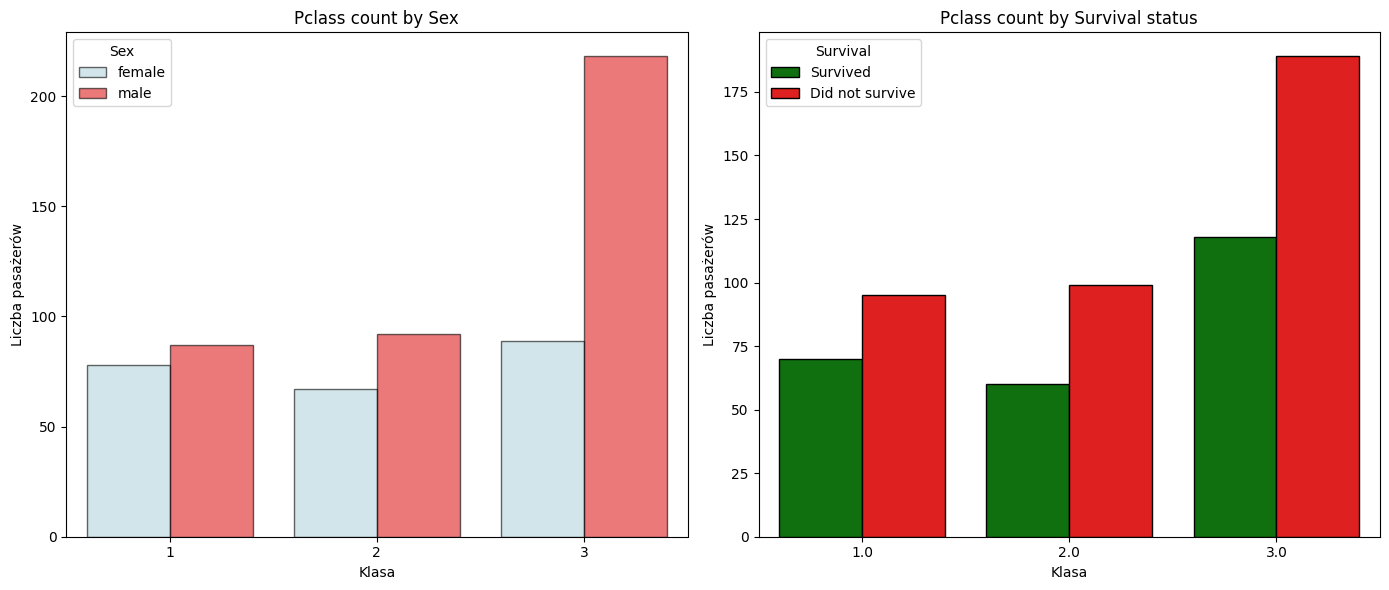

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sb.countplot(data=filtered_data, x='Pclass', hue=filtered_data['Is male'].map({1: 'male', 0: 'female'}), palette={"male": "red", "female": "lightblue"}, edgecolor='black', ax=axes[0], alpha=0.6)
axes[0].set_title("Pclass count by Sex")
axes[0].set_xlabel("Klasa")
axes[0].set_ylabel("Liczba pasażerów")
axes[0].legend(title='Sex')

sb.countplot(data=filtered_data, x='Pclass', hue=survival.map({1: 'Survived', 0: 'Did not survive'}), palette={"Survived": "green", "Did not survive": "red"}, edgecolor='black', ax=axes[1])
axes[1].set_title("Pclass count by Survival status")
axes[1].set_xlabel("Klasa")
axes[1].set_ylabel("Liczba pasażerów")
axes[1].legend(title='Survival')

plt.tight_layout()
plt.show()


Jak widać najwięcej mężczyzn jest w klasie 3 (najniższej) i ta właśnie klasa wykazuje największą śmiertelność co zgadza się z wykresem śmiertelności od płci. Im lepszą klasę pasażer miał wykupioną, tym większa była szansa że zdołał przeżyć.

# Przygotowanie do danych:

częściowo dane zostały już przygotowane (usunięcie wierszy z brakującymi rejestrami, onehotencoding płci). Z racji, że wiek ma dużo dosyć szeroko rozsianych wartości, zastosuję dla tej cechy skalowanie minmax aby nie odstawała wartościami aż tak bardzo od innych cech. Dodatkowo cecha fare nie jest potrzebna ponieważ mocno koreluje chociażby z pclass tak samo jak cecha Sibs koreluje z cechą Parch więc te dwie cechy również usuniemy

In [79]:
filtered_data.drop(['SibSp','Fare'], inplace=True, axis=1)

scaler = MinMaxScaler()
age_scal = scaler.fit_transform(filtered_data[['Age']])
age_scal = pd.DataFrame(age_scal, columns=['Age_scaled'])

data = filtered_data.drop(['Age'], axis=1).reset_index(drop=True)
age_scal = age_scal.reset_index(drop=True)
data = pd.concat([data, age_scal], axis=1)



# Dane przygotowane do uczenia maszynowego:

In [80]:
print(data)

     Pclass  Parch  Is male  Age_scaled
0         3      0      1.0    0.271174
1         1      0      0.0    0.472229
2         3      0      0.0    0.321438
3         1      0      0.0    0.434531
4         3      0      1.0    0.434531
..      ...    ...      ...         ...
626       3      0      1.0    0.308872
627       2      0      1.0    0.334004
628       1      0      0.0    0.233476
629       1      0      1.0    0.321438
630       3      0      1.0    0.396833

[631 rows x 4 columns]
